<a href="https://colab.research.google.com/github/sarthakgupta/Deep-Learning-Hands-On/blob/master/GAN_HandsOn_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

import keras
import tensorflow as tf
tf.enable_eager_execution()
# tf.__version__
tf.executing_eagerly()
from tensorflow.keras import layers

from IPython import display

Using TensorFlow backend.


In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5 # Normalize the images to [-1, 1]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(784, activation=tf.nn.tanh, use_bias=True))
    model.add(layers.Reshape((28, 28, 1)))

    return model


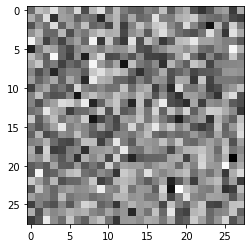

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(64, activation=tf.nn.tanh, use_bias=True))
    model.add(layers.Dense(1, activation=tf.nn.tanh, use_bias=True))

    return model
    

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.56965953]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    # display.clear_output(wait=True)
    if((epoch+1)%2==0):
      generate_and_save_images(generator, epoch + 1,seed)
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  # fig = plt.figure(figsize=(4,4))
  plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


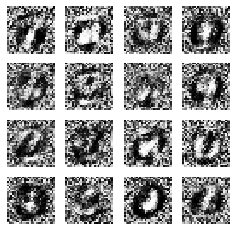

Time for epoch 2 is 18.326642751693726 sec


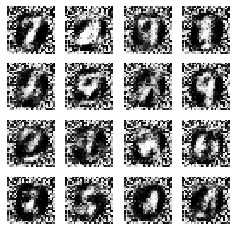

Time for epoch 4 is 18.215227127075195 sec


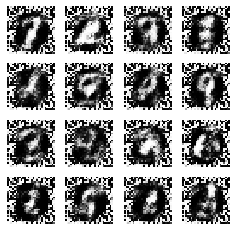

Time for epoch 6 is 18.38543152809143 sec


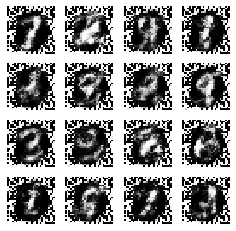

Time for epoch 8 is 18.172123908996582 sec


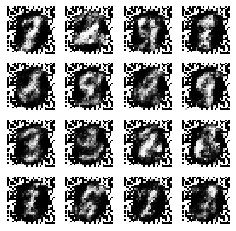

Time for epoch 10 is 18.597459077835083 sec


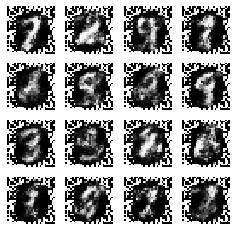

Time for epoch 12 is 18.525221347808838 sec


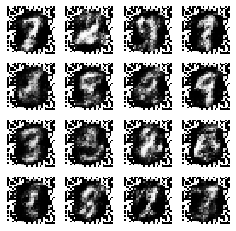

Time for epoch 14 is 18.369174242019653 sec


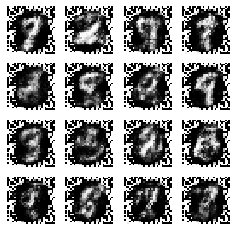

Time for epoch 16 is 18.380874395370483 sec


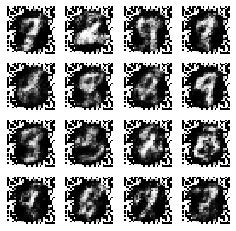

Time for epoch 18 is 18.417545318603516 sec


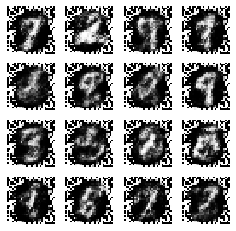

Time for epoch 20 is 17.984851121902466 sec


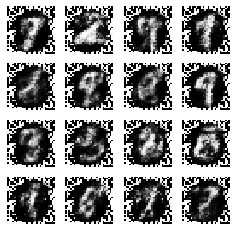

Time for epoch 22 is 18.514860153198242 sec


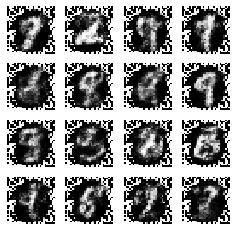

Time for epoch 24 is 18.040148496627808 sec


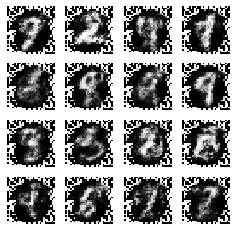

Time for epoch 26 is 18.68964958190918 sec


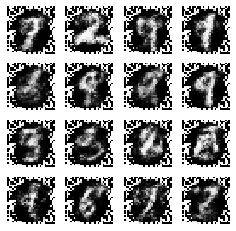

Time for epoch 28 is 18.363681316375732 sec


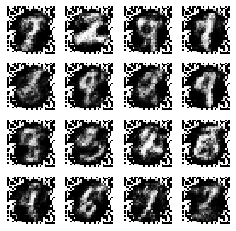

Time for epoch 30 is 18.92355179786682 sec


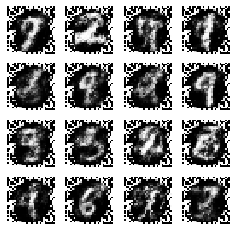

Time for epoch 32 is 19.001444101333618 sec


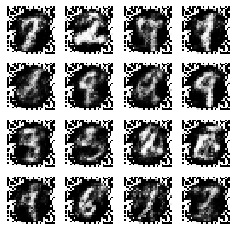

Time for epoch 34 is 18.3703191280365 sec


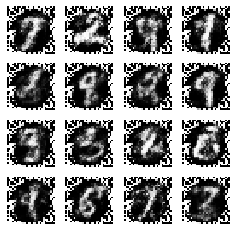

Time for epoch 36 is 17.51076602935791 sec


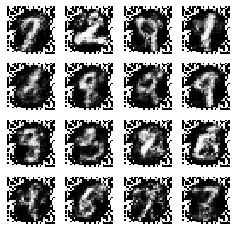

Time for epoch 38 is 18.382895469665527 sec


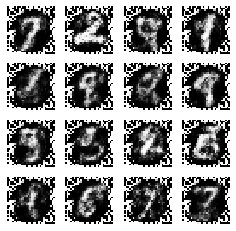

Time for epoch 40 is 18.40553903579712 sec


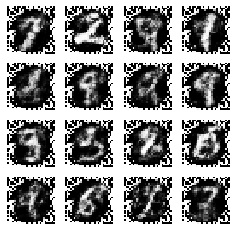

Time for epoch 42 is 18.5661039352417 sec


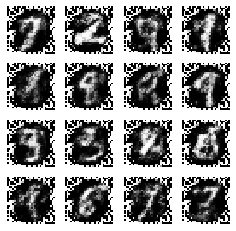

Time for epoch 44 is 18.380665063858032 sec


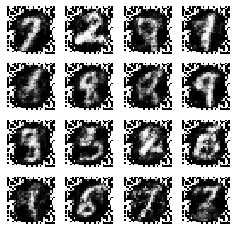

Time for epoch 46 is 18.16367268562317 sec


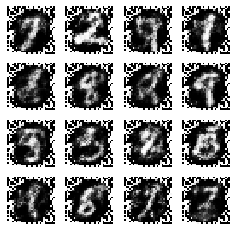

Time for epoch 48 is 18.319427967071533 sec


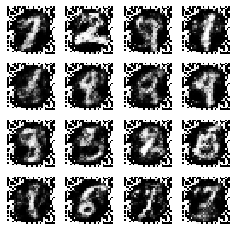

Time for epoch 50 is 18.435344219207764 sec


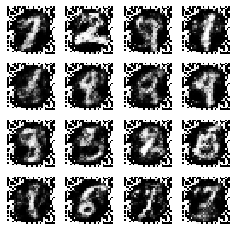

In [0]:
train(train_dataset, EPOCHS)